IMPORTING LIBRARIES

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Preprocessing
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# BERT
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import BertConfig

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Setup
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**LOADING AND LABELING DATASET**

In [2]:
from google.colab import drive
drive.mount('/content/drive')
real_filepath = "/content/drive/MyDrive/Colab Notebooks/Assignment Dataset/True.csv"
fake_filepath = "/content/drive/MyDrive/Colab Notebooks/Assignment Dataset/Fake.csv"
real = pd.read_csv(real_filepath)
fake = pd.read_csv(fake_filepath)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
real

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


In [4]:
fake

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [5]:
# Labelling
real["label"] = 1
fake["label"] = 0

In [6]:
# Combine and shuffle
news = pd.concat([real, fake], axis=0).reset_index(drop=True)
news = news.sample(frac=1, random_state=42).reset_index(drop=True)

In [7]:
# Preview
news.head()

,title,text,subject,date,label
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",0
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",0
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",0
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",1
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",0


In [8]:
# Cleaning
def clean_text(text):
    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove stopwords
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)

# Application
news['clean_text'] = news['text'].apply(lambda x: clean_text(str(x)))

# Preview
news[['text', 'clean_text']].head()

,text,clean_text
0,"Donald Trump s White House is in chaos, and th...",donald trump white house chaos trying cover ru...
1,Now that Donald Trump is the presumptive GOP n...,donald trump presumptive gop nominee time reme...
2,Mike Pence is a huge homophobe. He supports ex...,mike pence huge homophobe supports exgay conve...
3,SAN FRANCISCO (Reuters) - California Attorney ...,san francisco reuters california attorney gene...
4,Twisted reasoning is all that comes from Pelos...,twisted reasoning comes pelosi days especially...


In [9]:
news.head()

,title,text,subject,date,label,clean_text
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",0,donald trump white house chaos trying cover ru...
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",0,donald trump presumptive gop nominee time reme...
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",0,mike pence huge homophobe supports exgay conve...
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",1,san francisco reuters california attorney gene...
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",0,twisted reasoning comes pelosi days especially...


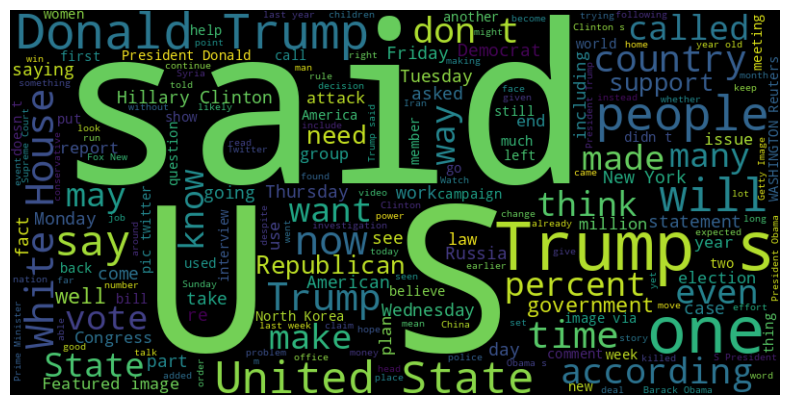

In [10]:
# Wordcloud
from wordcloud import WordCloud

text_data = ' '.join(news['text'].astype(str).tolist())
wordcloud = WordCloud(width=800, height=400).generate(text_data)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

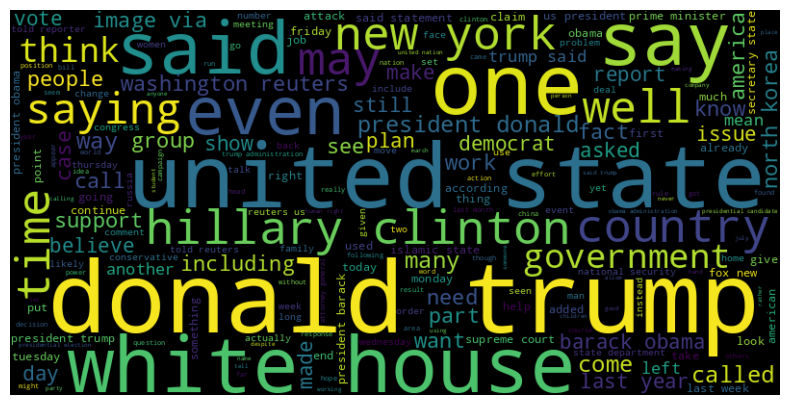

In [11]:
# Wordcloud
from wordcloud import WordCloud

text_data = ' '.join(news['clean_text'].astype(str).tolist())
wordcloud = WordCloud(width=800, height=400).generate(text_data)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [12]:
# BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# BERT max length
MAX_LEN = 512

# Tokenize data
bert_inputs = tokenizer(
    list(news['clean_text']),
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_tensors='tf',
    return_attention_mask=True)

# Tokenized shapes
print(f"Input IDs shape: {bert_inputs['input_ids'].shape}")
print(f"Attention mask shape: {bert_inputs['attention_mask'].shape}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Input IDs shape: (44898, 512)
Attention mask shape: (44898, 512)


In [13]:
# Parameters
input_ids = bert_inputs['input_ids'].numpy()
attention_masks = bert_inputs['attention_mask'].numpy()
labels = news['label'].values

# Split dataset
train_input_ids, test_input_ids, train_attention, test_attention, train_labels, test_labels = train_test_split(
    input_ids,
    attention_masks,
    labels,
    test_size=0.3,
    stratify=labels,
    random_state=1313
)

In [14]:
from transformers import create_optimizer

# BERT model
bert_model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2
)

# Optimizer and scheduler
optimizer, schedule = create_optimizer(
    init_lr=0.00002,
    num_warmup_steps=0,
    num_train_steps=1000
)

# Compile model
bert_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Model structure
bert_model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
# Train model
history = bert_model.fit(
    x={
        'input_ids': train_input_ids,
        'attention_mask': train_attention
    },
    y=train_labels,
    validation_data=(
        {
            'input_ids': test_input_ids,
            'attention_mask': test_attention
        },
        test_labels
    ),
    epochs=10,
    batch_size=16
)
history_base = history


Epoch 1/10
1965/1965 [==============================] - 561s 264ms/step - loss: 0.0225 - accuracy: 0.9932 - val_loss: 0.0038 - val_accuracy: 0.9994
Epoch 2/10
1965/1965 [==============================] - 507s 258ms/step - loss: 0.0042 - accuracy: 0.9993 - val_loss: 0.0038 - val_accuracy: 0.9994
Epoch 3/10
1965/1965 [==============================] - 504s 257ms/step - loss: 0.0049 - accuracy: 0.9991 - val_loss: 0.0038 - val_accuracy: 0.9994
Epoch 4/10
1965/1965 [==============================] - 504s 257ms/step - loss: 0.0044 - accuracy: 0.9993 - val_loss: 0.0038 - val_accuracy: 0.9994
Epoch 5/10
1965/1965 [==============================] - 504s 256ms/step - loss: 0.0048 - accuracy: 0.9991 - val_loss: 0.0038 - val_accuracy: 0.9994
Epoch 6/10
1965/1965 [==============================] - 504s 256ms/step - loss: 0.0042 - accuracy: 0.9993 - val_loss: 0.0038 - val_accuracy: 0.9994
Epoch 7/10
1965/1965 [==============================] - 504s 256ms/step - loss: 0.0048 - accuracy: 0.9991 - val_

In [16]:
# Save BERT model
bert_model.save_pretrained('/content/drive/MyDrive/bert_fake_news_model')
tokenizer.save_pretrained('/content/drive/MyDrive/bert_fake_news_model')


('/content/drive/MyDrive/bert_fake_news_model/tokenizer_config.json',
 '/content/drive/MyDrive/bert_fake_news_model/special_tokens_map.json',
 '/content/drive/MyDrive/bert_fake_news_model/vocab.txt',
 '/content/drive/MyDrive/bert_fake_news_model/added_tokens.json')

In [17]:
# Load BERT model
from transformers import TFBertForSequenceClassification, BertTokenizer

loaded_bert = TFBertForSequenceClassification.from_pretrained('/content/drive/MyDrive/bert_fake_news_model')
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/bert_fake_news_model')


Some layers from the model checkpoint at /content/drive/MyDrive/bert_fake_news_model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/bert_fake_news_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [18]:
# Prepare test dataset from existing splits
test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': test_input_ids,
        'attention_mask': test_attention
    },
    test_labels
)).batch(16)

# Predict
preds = loaded_bert.predict(test_dataset)
y_pred = np.argmax(preds.logits, axis=1)


842/842 [==============================] - 71s 80ms/step


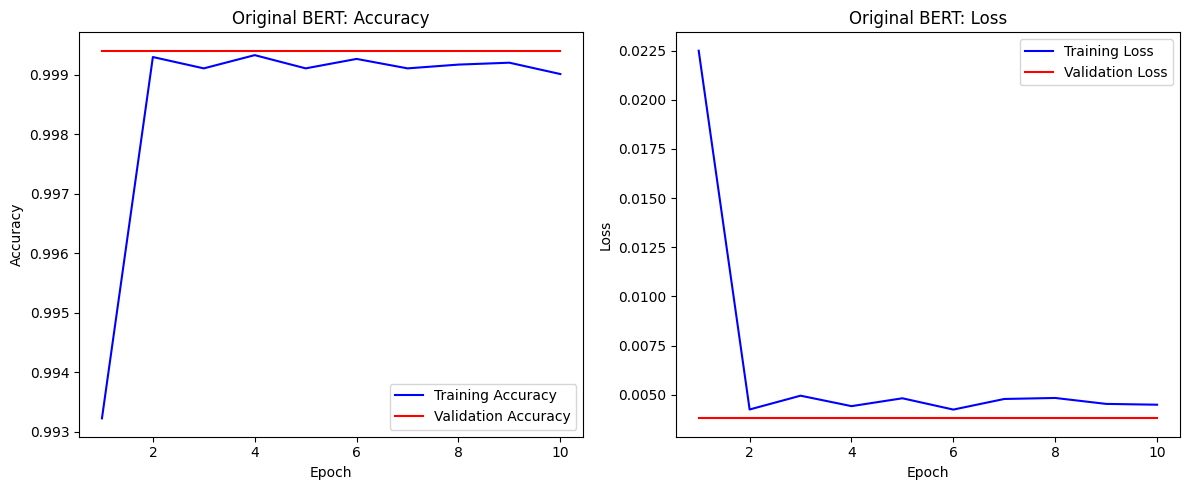

In [19]:
# Extract metrics from base model
acc_base = history_base.history['accuracy']
val_acc_base = history_base.history['val_accuracy']
loss_base = history_base.history['loss']
val_loss_base = history_base.history['val_loss']
epochs_base = range(1, len(acc_base) + 1)

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Accuracy plot
axes[0].plot(epochs_base, acc_base, 'b', label='Training Accuracy')
axes[0].plot(epochs_base, val_acc_base, 'r', label='Validation Accuracy')
axes[0].set_title('Original BERT: Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Loss plot
axes[1].plot(epochs_base, loss_base, 'b', label='Training Loss')
axes[1].plot(epochs_base, val_loss_base, 'r', label='Validation Loss')
axes[1].set_title('Original BERT: Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()


Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      7045
        Real       1.00      1.00      1.00      6425

    accuracy                           1.00     13470
   macro avg       1.00      1.00      1.00     13470
weighted avg       1.00      1.00      1.00     13470



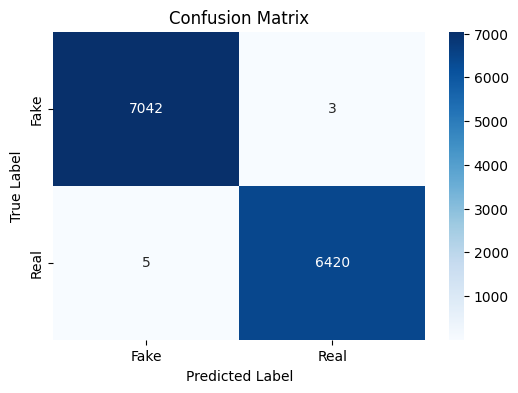

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Classification Report
print("Classification Report:")
print(classification_report(test_labels, y_pred, target_names=['Fake', 'Real']))

# Confusion Matrix
cm = confusion_matrix(test_labels, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
1965/1965 [==============================] - ETA: 0s - loss: 0.0289 - accuracy: 0.9897
Epoch 1: val_accuracy improved from -inf to 0.99777, saving model to /content/drive/MyDrive/bert_tuned_model_best.keras


/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


1965/1965 [==============================] - 563s 267ms/step - loss: 0.0289 - accuracy: 0.9897 - val_loss: 0.0089 - val_accuracy: 0.9978
Epoch 2/10
1965/1965 [==============================] - ETA: 0s - loss: 0.0071 - accuracy: 0.9981
Epoch 2: val_accuracy did not improve from 0.99777
1965/1965 [==============================] - 505s 257ms/step - loss: 0.0071 - accuracy: 0.9981 - val_loss: 0.0089 - val_accuracy: 0.9978
Epoch 3/10
1965/1965 [==============================] - ETA: 0s - loss: 0.0070 - accuracy: 0.9982
Epoch 3: val_accuracy did not improve from 0.99777
842/842 [==============================] - 71s 80ms/step
Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      7045
        Real       1.00      1.00      1.00      6425

    accuracy                           1.00     13470
   macro avg       1.00      1.00      1.00     13470
weighted avg       1.00      1.00      1.00     13470



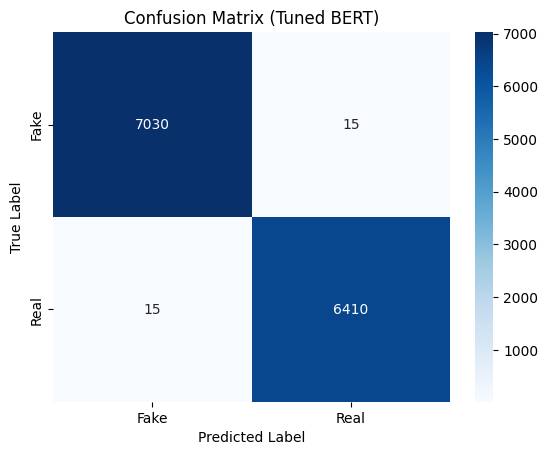

In [21]:
import tensorflow as tf
from transformers import TFBertForSequenceClassification, create_optimizer
from tf_keras.src.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Create TensorFlow Datasets
train_dataset_tuned = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': train_input_ids,
        'attention_mask': train_attention
    },
    train_labels
)).batch(16)

val_dataset_tuned = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': test_input_ids,
        'attention_mask': test_attention
    },
    test_labels
)).batch(16)

# Model Setup
bert_model_tuned = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    hidden_dropout_prob=0.3
)

# Optimizer
optimizer_tuned, schedule_tuned = create_optimizer(
    init_lr=0.00003,
    num_train_steps=1000,
    num_warmup_steps=0
)

bert_model_tuned.compile(
    optimizer=optimizer_tuned,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Callbacks
early_stop_tuned = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

checkpoint_tuned = ModelCheckpoint(
    filepath='/content/drive/MyDrive/bert_tuned_model_best.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Train Tuned Model
history_tuned = bert_model_tuned.fit(
    train_dataset_tuned,
    validation_data=val_dataset_tuned,
    epochs=10,
    callbacks=[early_stop_tuned, checkpoint_tuned]
)

# Save final model
bert_model_tuned.save('/content/drive/MyDrive/bert_tuned_model_final.keras', save_format='keras')


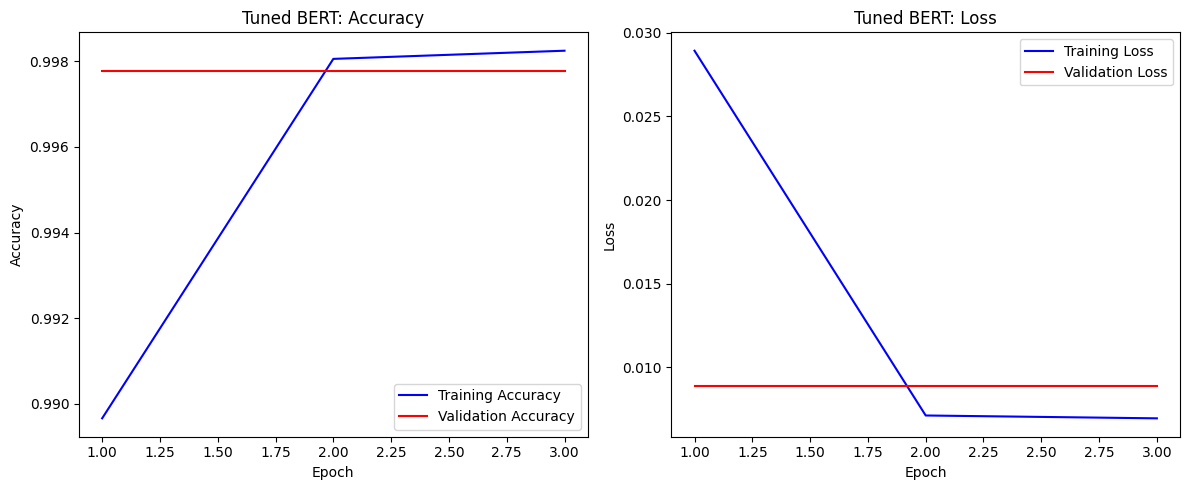

In [22]:
# Extract metrics from tuned model
acc_tuned = history_tuned.history['accuracy']
val_acc_tuned = history_tuned.history['val_accuracy']
loss_tuned = history_tuned.history['loss']
val_loss_tuned = history_tuned.history['val_loss']
epochs_tuned = range(1, len(acc_tuned) + 1)

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Accuracy plot
axes[0].plot(epochs_tuned, acc_tuned, 'b', label='Training Accuracy')
axes[0].plot(epochs_tuned, val_acc_tuned, 'r', label='Validation Accuracy')
axes[0].set_title('Tuned BERT: Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Loss plot
axes[1].plot(epochs_tuned, loss_tuned, 'b', label='Training Loss')
axes[1].plot(epochs_tuned, val_loss_tuned, 'r', label='Validation Loss')
axes[1].set_title('Tuned BERT: Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Show the plots
plt.tight_layout()
plt.show()


842/842 [==============================] - 68s 80ms/step
Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      7045
        Real       1.00      1.00      1.00      6425

    accuracy                           1.00     13470
   macro avg       1.00      1.00      1.00     13470
weighted avg       1.00      1.00      1.00     13470



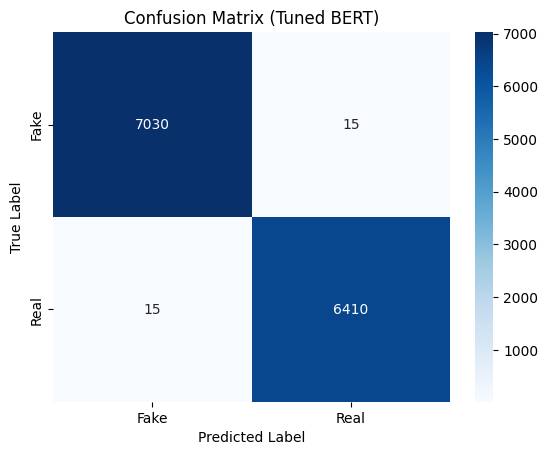

In [23]:
# Evaluation
preds_tuned = bert_model_tuned.predict(val_dataset_tuned)
y_pred_tuned = np.argmax(preds_tuned.logits, axis=1)

# True labels
y_true_tuned = []
for _, label in val_dataset_tuned:
    y_true_tuned.extend(label.numpy())

# Classification Report
print("Classification Report:")
print(classification_report(y_true_tuned, y_pred_tuned, target_names=['Fake', 'Real']))

# Confusion Matrix
cm_tuned = confusion_matrix(y_true_tuned, y_pred_tuned)
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Tuned BERT)')
plt.show()


**LSTM**

In [24]:
from google.colab import drive
drive.mount('/content/drive')

# Path to GloVe file
glove_path = "/content/drive/MyDrive/glove.6B.100d.txt"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import numpy as np

# load GloVE
embedding_index = {}

with open(glove_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

print(f"Loaded {len(embedding_index)} word vectors.")


Loaded 400000 word vectors.


In [26]:
# Tokenization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
max_length = 200
embedding_dim = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(news['clean_text'])

sequences = tokenizer.texts_to_sequences(news['clean_text'])
padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

labels = news['label'].values


In [27]:
# Embedding matrix
word_index = tokenizer.word_index
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


In [28]:
# Split dataset
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(padded, labels, test_size=0.3, stratify=labels, random_state=1333)


In [29]:
# LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

lstm_base = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=max_length,
              weights=[embedding_matrix],
              trainable=False),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

lstm_base.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_base.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

In [30]:
# Train model
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history_base = lstm_base.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)


Epoch 1/10
983/983 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.6487 - loss: 0.6150 - val_accuracy: 0.5810 - val_loss: 0.6836
Epoch 2/10
983/983 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.7292 - loss: 0.4852 - val_accuracy: 0.9934 - val_loss: 0.0321
Epoch 3/10
983/983 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.9969 - loss: 0.0169 - val_accuracy: 0.9972 - val_loss: 0.0165
Epoch 4/10
983/983 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9976 - loss: 0.0104 - val_accuracy: 0.9975 - val_loss: 0.0101
Epoch 5/10
983/983 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9985 - loss: 0.0081 - val_accuracy: 0.9973 - val_loss: 0.0125
Epoch 6/10
983/983 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9981 - loss: 0.0097 - val_accuracy: 0.9978 - val_loss: 0.0128


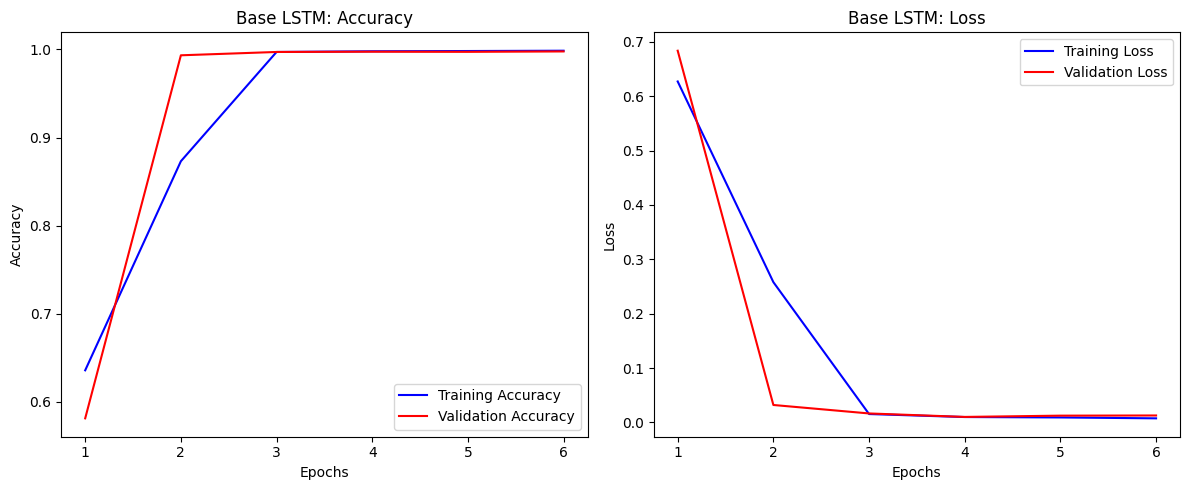

In [31]:
# Accuracy and loss plot
import matplotlib.pyplot as plt

acc_base = history_base.history['accuracy']
val_acc_base = history_base.history['val_accuracy']
loss_base = history_base.history['loss']
val_loss_base = history_base.history['val_loss']
epochs_base = range(1, len(acc_base) + 1)

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_base, acc_base, 'b', label='Training Accuracy')
plt.plot(epochs_base, val_acc_base, 'r', label='Validation Accuracy')
plt.title('Base LSTM: Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_base, loss_base, 'b', label='Training Loss')
plt.plot(epochs_base, val_loss_base, 'r', label='Validation Loss')
plt.title('Base LSTM: Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


421/421 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Classification Report (Base LSTM):
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      7045
        Real       1.00      1.00      1.00      6425

    accuracy                           1.00     13470
   macro avg       1.00      1.00      1.00     13470
weighted avg       1.00      1.00      1.00     13470



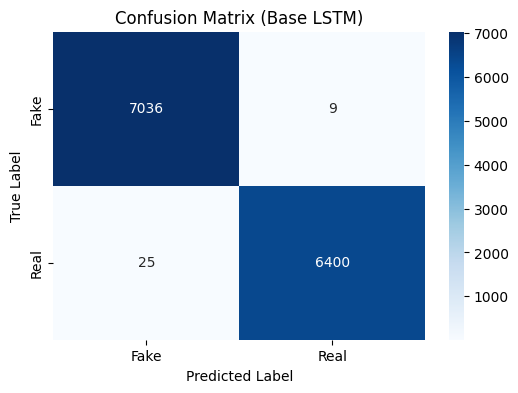

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Predict
y_pred_base = (lstm_base.predict(X_val) > 0.5).astype("int32")

# Classification Report
print("Classification Report (Base LSTM):")
print(classification_report(y_val, y_pred_base, target_names=['Fake', 'Real']))

# Confusion Matrix
cm_base = confusion_matrix(y_val, y_pred_base)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Base LSTM)')
plt.show()


In [33]:
# Tuned LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

lstm_tuned = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=max_length,
              weights=[embedding_matrix],
              trainable=False),
    LSTM(128, return_sequences=True),
    Dropout(0.4),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

lstm_tuned.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

early_stop_tuned = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train model
history_tuned_lstm = lstm_tuned.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop_tuned]
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


492/492 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.6526 - loss: 0.6159 - val_accuracy: 0.8062 - val_loss: 0.5130
Epoch 2/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9541 - loss: 0.1645 - val_accuracy: 0.9024 - val_loss: 0.2708
Epoch 3/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.8966 - loss: 0.2818 - val_accuracy: 0.8895 - val_loss: 0.2930
Epoch 4/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.8932 - loss: 0.2859 - val_accuracy: 0.8918 - val_loss: 0.2890
Epoch 5/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.8966 - loss: 0.2848 - val_accuracy: 0.8614 - val_loss: 0.3546


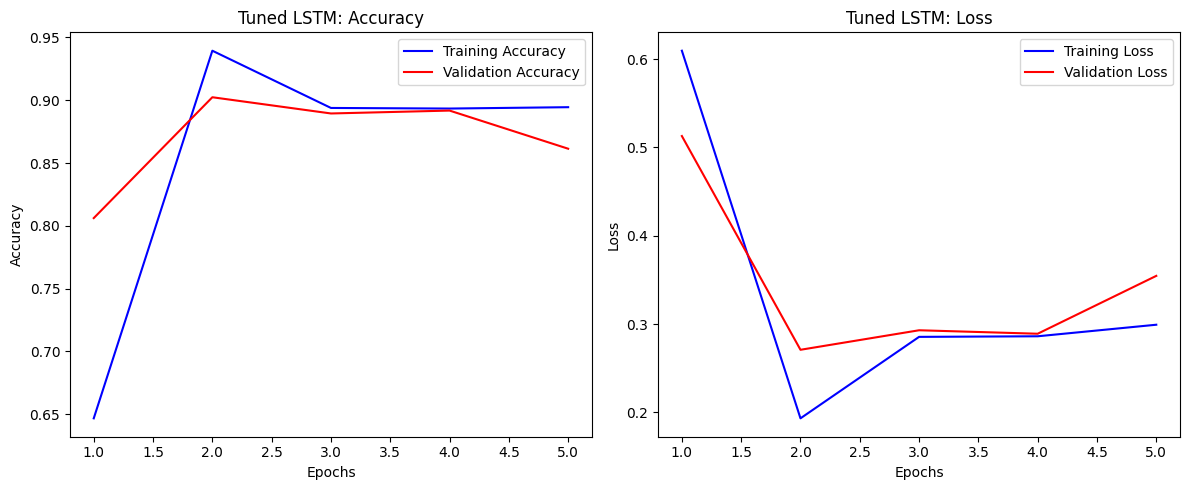

In [34]:
# Accuracy and loss plot
acc_tuned = history_tuned_lstm.history['accuracy']
val_acc_tuned = history_tuned_lstm.history['val_accuracy']
loss_tuned = history_tuned_lstm.history['loss']
val_loss_tuned = history_tuned_lstm.history['val_loss']
epochs_tuned = range(1, len(acc_tuned) + 1)

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_tuned, acc_tuned, 'b', label='Training Accuracy')
plt.plot(epochs_tuned, val_acc_tuned, 'r', label='Validation Accuracy')
plt.title('Tuned LSTM: Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_tuned, loss_tuned, 'b', label='Training Loss')
plt.plot(epochs_tuned, val_loss_tuned, 'r', label='Validation Loss')
plt.title('Tuned LSTM: Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


421/421 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Classification Report (Tuned LSTM):
              precision    recall  f1-score   support

        Fake       1.00      0.82      0.90      7045
        Real       0.83      1.00      0.91      6425

    accuracy                           0.90     13470
   macro avg       0.91      0.91      0.90     13470
weighted avg       0.92      0.90      0.90     13470



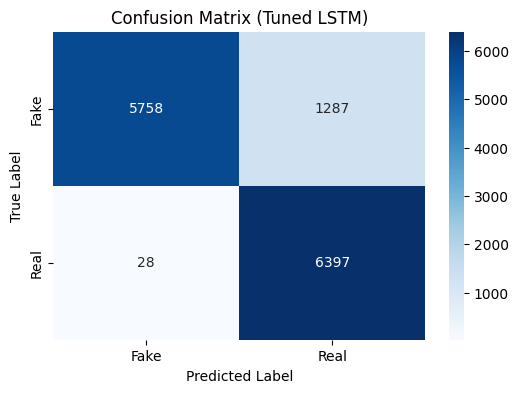

In [35]:
# Predict
y_pred_tuned = (lstm_tuned.predict(X_val) > 0.5).astype("int32")

# Classification Report
print("Classification Report (Tuned LSTM):")
print(classification_report(y_val, y_pred_tuned, target_names=['Fake', 'Real']))

# Confusion Matrix
cm_tuned = confusion_matrix(y_val, y_pred_tuned)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Tuned LSTM)')
plt.show()
